In [79]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from fairlearn import datasets
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate


In [80]:
def sensitive_pdfs(df, sensitive_features): 
    distinct_features_vals = []
    df_dict = {}
    for feature in sensitive_features:
        distinct_vals = set(df[feature].to_list())
        distinct_features_vals.append(distinct_vals)
    distinct_features_combos = list(product(*distinct_features_vals))
    for features in distinct_features_combos:
        query = " & ".join([f"{sensitive_features[i]} == '{features[i]}'" for i in range(len(sensitive_features))])
        filtered_df = df.query(query)
        key = tuple(sorted(features))
        df_dict[key] = filtered_df 
    return df_dict

In [81]:
def plot_auc(df, y_pred, y_true, name, ax=None):
    y_pred_r = np.asarray(df[y_pred]).astype(float)
    y_true_r = np.asarray(df[y_true]).astype(int)

    fpr, tpr, _ = roc_curve(y_true_r, y_pred_r, pos_label=1)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=ax)
    return display

# Load data

In [82]:
# Load data
data = datasets.fetch_adult(as_frame=True)['data']
target = datasets.fetch_adult(as_frame=True)['target']

In [83]:
assert(len(target == len(data)))
print(len(target))
print(set(target))
data.head(3)

48842
{'>50K', '<=50K'}


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States


In [84]:
# Extract into X, y and A
sensitive_features = ['sex', 'race']
data_cols = [x for x in data if x not in sensitive_features]

# Predictors
ohe = OneHotEncoder()
X = ohe.fit_transform(data[data_cols])

le = LabelEncoder()
y = le.fit_transform(target)
A = data[sensitive_cols]

In [85]:
# Split into test and train, making sure we have sequential indices in the results
X_train, X_test, y_train, y_test, A_train, A_test = \
    train_test_split(X, Y, A, test_size=0.33, random_state=123)

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# A_train = A_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
# A_test = A_test.reset_index(drop=True)

In [76]:
# Fit unmitigated model
unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, y_train)
y_pred = unmitigated_predictor.predict(X_train)
plot_auc(df, y_pred=y_pred, y_true=y_test, name, ax=None)

LogisticRegression(solver='liblinear')

In [86]:
sensitive_pdfs_dict = sensitive_pdfs(data, sensitive_features)

In [90]:
len(sensitive_pdfs_dict.keys())

10

In [98]:
group = sensitive_pdfs_dict[('Amer-Indian-Eskimo', 'Male')]
group_plot = plot_auc(sensitive_pdfs_dict[grouping],"matching_score","golden_label", grouping, ax)

In [99]:
help(plot_auc)

Help on function plot_auc in module __main__:

plot_auc(df, y_pred, y_true, name, ax=None)



KeyError: 'matching_score'

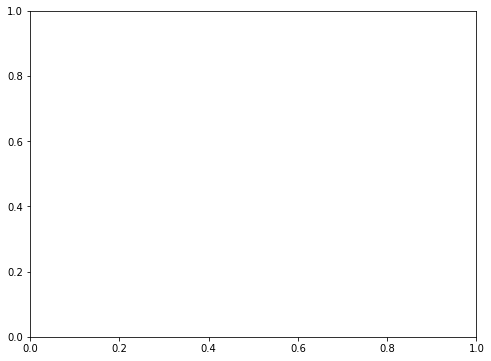

In [92]:
sensitive_pdfs_dict=sensitive_pdfs(data, sensitive_features)
plt.figure(figsize=(8, 6))
ax = plt.gca()
for grouping in sensitive_pdfs_dict: 
    group_plot = plot_auc(sensitive_pdfs_dict[grouping],"matching_score","golden_label", grouping, ax)